In [ ]:
# title: "Test-retest reliability of functional connectivity in depressed adolescents"
# author: "Chris C. Camp, Stephanie Noble, Dustin Scheinost, Argyris Stringaris, and Dylan M. Nielson"
# date: '2022-12-17'

# This code uses the ICC file to generate Fig. 1

In [1]:
from pathlib import Path
from nilearn import datasets, image, plotting, input_data, masking
#from bids import BIDSLayout
from ast import literal_eval
from io import StringIO
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import ast

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 1000)

from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

/gpfs/ysm/project/scheinost/ccc98/conda_envs/brain/lib/python3.10/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/tmp/ipykernel_198359/2788353986.py:19: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
project_root = Path('/home/ccc98/Documents/ReliabilityAnalysis')
ts_dir = project_root / 'data' / 'raw' / 'all_timeseries' / 'ts_extract_allmodels'
database_path = project_root / 'references' / 'rest_paths_v21.csv'
rest_paths = pd.read_csv(database_path)
rest_paths = rest_paths[[col for col in rest_paths.columns if "path" not in col]]
rest_paths['entities'] = rest_paths['entities'].apply(lambda x: literal_eval(x))

In [4]:
atlas_path = project_root / 'data' / 'processed' / 'atlases' / 'basc_122_nearest_atlas.nii.gz'
regions_extracted_img = image.load_img(str(atlas_path))
basc = datasets.fetch_atlas_basc_multiscale_2015(version='asym')

In [9]:
iccs[1:3]

,measure,icc_mean,icc_sd,group,m1,m2
1,10_0,0.219977,0.123909,hv,10,0
2,10_1,0.261885,0.153571,hv,10,1


In [5]:
# Don't use this

#Creates dataframe with new indices for 4th dim
basc = datasets.fetch_atlas_basc_multiscale_2015(version='asym')
atlas = image.load_img(basc['scale122'])
atlas_dat = atlas.get_fdata()
uvs = np.unique(atlas_dat)
atlas_in_4d = []
for uv in uvs:
    atlas_in_4d.append((atlas_dat == uv).astype(int))
atlas_4d_dat = np.array(atlas_in_4d)
atlas_dfs = []
for ii, aa in enumerate(atlas_in_4d):
    row = {}
    row['orig_ind'] = ii
    row['x_min'], row['y_min'], row['z_min'] = np.array(np.where(aa)).min(1)
    row['x_max'], row['y_max'], row['z_max'] = np.array(np.where(aa)).max(1)
    row['x_mean'], row['y_mean'], row['z_mean'] = np.array(np.where(aa)).mean(1)
    atlas_dfs.append(row)
atlas_dfs = pd.DataFrame(atlas_dfs)
atlas_df = atlas_dfs.sort_values('y_min', ascending=False).reset_index(drop=True).reset_index().rename(columns={'index':'new_index'})
atlas_df['match_ind'] = atlas_df.orig_ind + 1000
atlas_df['new_index'] +=1
atlas_df.loc[atlas_df['match_ind'] == 1000, 'new_index']=0
sorted_dat = atlas_dat + 1000

# Get average ICCs for each region
iccs = pd.read_csv(project_root / 'data' / 'output' / 'bootstrapped_icc_means_v21.csv')
iccs = iccs.loc[iccs['type'] == "ICC2"].reset_index()
iccs = pd.concat([iccs, pd.DataFrame(iccs.measure.str.split('_').tolist(),columns=['m1', 'm2'])], axis=1)
iccs['m1'] = iccs['m1'].astype('int')
iccs['m2'] = iccs['m2'].astype('int')
means = []
for i in range(len(np.unique(sorted_dat)) - 1):
    means.append(np.mean(iccs[(iccs['m1'] == i) | (iccs['m2'] == i)]['ICC']))
ns_means = means
orig_inds = np.unique(sorted_dat)
sub = means - np.min(means)
means = np.divide(sub, max(sub)) * 100

#Creates 4th dim from ICCs
atlas_df_trun = atlas_df.iloc[:-1]
atlas_df_trun['iccs'] = means
for ii, row in atlas_df_trun.iterrows():
    sorted_dat[sorted_dat == row.match_ind] = row.iccs
sorted_atlas = image.new_img_like(atlas, sorted_dat, atlas.affine, atlas.header)
uvs = np.unique(atlas_df_trun.iccs)
atlas_in_4d = np.zeros(list(atlas.shape) + [len(uvs)-1], dtype=int)
for ii, uv in enumerate(uvs):
    if uv != 0:
        atlas_in_4d[:,:,:,ii-1] = (sorted_dat == uv).astype(int)
sorted_4d_img = image.new_img_like(atlas,atlas_in_4d, affine=atlas.affine,copy_header=True)
# for ii, row in atlas_df.iterrows():
#     sorted_dat[sorted_dat == row.match_ind] = row.new_index
# sorted_atlas = image.new_img_like(atlas, sorted_dat, atlas.affine, atlas.header)
# uvs = np.unique(sorted_dat)
# atlas_in_4d = np.zeros(list(atlas.shape) + [len(uvs)-1], dtype=int)
# for ii, uv in enumerate(uvs):
#     if uv != 0:
#         atlas_in_4d[:,:,:,ii-1] = (sorted_dat == uv).astype(int)
# sorted_4d_img = image.new_img_like(atlas,atlas_in_4d, affine=atlas.affine,copy_header=True)


Dataset created in /home/ccc98/nilearn_data/basc_multiscale_2015



 ...done. (1 seconds, 0 min)
Extracting data from /home/ccc98/nilearn_data/basc_multiscale_2015/ad5c054e9394b45f33c4584c23fe7df3/1861820..... done.


KeyError: 'type'

In [28]:
atlas = image.load_img(basc['scale122'])
atlas_dat = atlas.get_fdata()
uvs = np.unique(atlas_dat)
hv_atlas = atlas_dat.copy()
mdd_atlas = atlas_dat.copy()
iccs = pd.read_csv(project_root / 'data' / 'output' / 'bootstrapped_icc_means_v21_1.csv')
iccs = pd.concat([iccs, pd.DataFrame(iccs.measure.str.split('_').tolist(),columns=['m1', 'm2'])], axis=1)
iccs['m1'] = iccs['m1'].astype('int')
iccs['m2'] = iccs['m2'].astype('int')
iccs['ICC'] = iccs['icc_mean']
means = []
mdd_iccs = iccs.loc[iccs.group == "mdd"].reset_index()
hv_iccs = iccs.loc[iccs.group == "hv"].reset_index()
for i in (uvs[1:]):
    means.append(np.mean(mdd_iccs[mdd_iccs['m1'] == (i-1)]['ICC'].append(mdd_iccs[mdd_iccs['m2'] == (i-1)]['ICC'])))
    means.append(np.mean(hv_iccs[hv_iccs['m1'] == (i-1)]['ICC'].append(hv_iccs[hv_iccs['m2'] == (i-1)]['ICC'])))
    mdd_atlas[np.where(atlas_dat == i)] = np.mean(mdd_iccs[(mdd_iccs['m1'] == (i-1)) | (mdd_iccs['m2'] == (i-1))]['ICC'])
    hv_atlas[np.where(atlas_dat == i)] = np.mean(hv_iccs[(hv_iccs['m1'] == (i-1)) | (hv_iccs['m2'] == (i-1))]['ICC'])
    # atlas_dat_flat = np.where(atlas_dat.flat == i, np.mean(iccs[(iccs['m1'] == i) | (iccs['m2'] == i)]['ICC']), atlas_dat.flat)
ns_means = means

/tmp/ipykernel_198359/3666149493.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(mdd_iccs[mdd_iccs['m1'] == (i-1)]['ICC'].append(mdd_iccs[mdd_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(hv_iccs[hv_iccs['m1'] == (i-1)]['ICC'].append(hv_iccs[hv_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(mdd_iccs[mdd_iccs['m1'] == (i-1)]['ICC'].append(mdd_iccs[mdd_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future

/tmp/ipykernel_198359/3666149493.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(hv_iccs[hv_iccs['m1'] == (i-1)]['ICC'].append(hv_iccs[hv_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(mdd_iccs[mdd_iccs['m1'] == (i-1)]['ICC'].append(mdd_iccs[mdd_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(hv_iccs[hv_iccs['m1'] == (i-1)]['ICC'].append(hv_iccs[hv_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future ver

/tmp/ipykernel_198359/3666149493.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(mdd_iccs[mdd_iccs['m1'] == (i-1)]['ICC'].append(mdd_iccs[mdd_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(hv_iccs[hv_iccs['m1'] == (i-1)]['ICC'].append(hv_iccs[hv_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(mdd_iccs[mdd_iccs['m1'] == (i-1)]['ICC'].append(mdd_iccs[mdd_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future

/tmp/ipykernel_198359/3666149493.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(hv_iccs[hv_iccs['m1'] == (i-1)]['ICC'].append(hv_iccs[hv_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(mdd_iccs[mdd_iccs['m1'] == (i-1)]['ICC'].append(mdd_iccs[mdd_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(hv_iccs[hv_iccs['m1'] == (i-1)]['ICC'].append(hv_iccs[hv_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future ver

/tmp/ipykernel_198359/3666149493.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(hv_iccs[hv_iccs['m1'] == (i-1)]['ICC'].append(hv_iccs[hv_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(mdd_iccs[mdd_iccs['m1'] == (i-1)]['ICC'].append(mdd_iccs[mdd_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(hv_iccs[hv_iccs['m1'] == (i-1)]['ICC'].append(hv_iccs[hv_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future ver

/tmp/ipykernel_198359/3666149493.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(mdd_iccs[mdd_iccs['m1'] == (i-1)]['ICC'].append(mdd_iccs[mdd_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(hv_iccs[hv_iccs['m1'] == (i-1)]['ICC'].append(hv_iccs[hv_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(mdd_iccs[mdd_iccs['m1'] == (i-1)]['ICC'].append(mdd_iccs[mdd_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future

/tmp/ipykernel_198359/3666149493.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(hv_iccs[hv_iccs['m1'] == (i-1)]['ICC'].append(hv_iccs[hv_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(mdd_iccs[mdd_iccs['m1'] == (i-1)]['ICC'].append(mdd_iccs[mdd_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(hv_iccs[hv_iccs['m1'] == (i-1)]['ICC'].append(hv_iccs[hv_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future ver

/tmp/ipykernel_198359/3666149493.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(mdd_iccs[mdd_iccs['m1'] == (i-1)]['ICC'].append(mdd_iccs[mdd_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(hv_iccs[hv_iccs['m1'] == (i-1)]['ICC'].append(hv_iccs[hv_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  means.append(np.mean(mdd_iccs[mdd_iccs['m1'] == (i-1)]['ICC'].append(mdd_iccs[mdd_iccs['m2'] == (i-1)]['ICC'])))
/tmp/ipykernel_198359/3666149493.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future

In [38]:
mdd_atlas_img = image.new_img_like(atlas,mdd_atlas,affine=atlas.affine, copy_header=True)
hv_atlas_img = image.new_img_like(atlas,hv_atlas,affine=atlas.affine, copy_header=True)

In [40]:
sub_atlas = mdd_atlas - hv_atlas

sub_atlas_img = image.new_img_like(atlas,sub_atlas, affine=atlas.affine,copy_header=True)

#sub__img.to_filename('sub_icc_img.nii.gz')

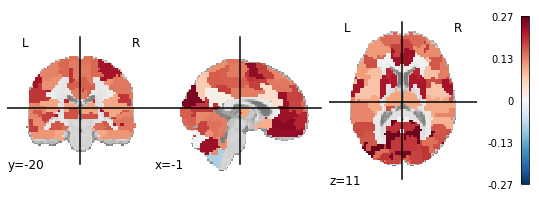

In [41]:
plotting.plot_stat_map(sub_atlas_img, cmap = "RdBu_r", colorbar=True)

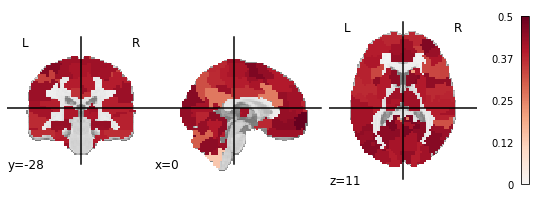

In [37]:
plotting.plot_stat_map(mdd_atlas_img, cmap = "RdBu_r")

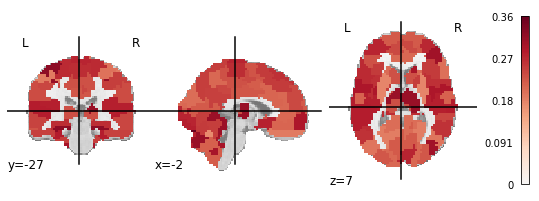

In [39]:
plotting.plot_stat_map(hv_atlas_img, cmap = "RdBu_r")

In [178]:
template = datasets.load_mni152_template(resolution=1)

In [179]:
shen = image.load_img('./shen_1mm_268_parcellation.nii.gz')

In [180]:
basc122_mni = image.resample_to_img(atlas,shen,interpolation='nearest')

In [185]:
basc122_mni.get_fdata().shape

(181, 217, 181)

In [182]:
basc122_mni.to_filename('./basc122_mni.nii.gz')

In [82]:
sub_icc = mdd_dat_icc - hv_dat_icc

sub_icc_img = image.new_img_like(atlas,sub_icc, affine=atlas.affine,copy_header=True)

sub_icc_img.to_filename('sub_icc_img.nii.gz')

/home/chris/miniconda3/envs/linenv/lib/python3.7/site-packages/nilearn/plotting/img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
/home/chris/miniconda3/envs/linenv/lib/python3.7/site-packages/nilearn/plotting/displays.py:103: UserWarning: No contour levels were found within the data range.
  **kwargs)


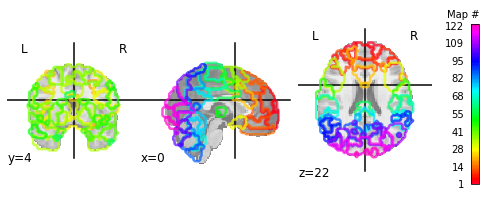

In [4]:
plotting.plot_prob_atlas(regions_extracted_img, colorbar=True)

# Normalizing RS Connectivities

In [104]:
dat_paths = pd.read_csv("/mnt/c/Users/chris/OneDrive - Yale University/NIH/Research/database pub/nilearn/nilearn/rest_df_ccmp.csv",index_col=0)

In [115]:
dat_paths[:2]

,subject,session,task,run,space,suffix,datatype,extension,entities,file,toc_path,mask_path,tsnr_path,events_path,phys1d_path,imgmeta_path,phys_path,physmeta_path,cfd_orig_path,cfd_new_path,nv,ms,has_phys,model_path,subj_out_dir,has_events,rest_ts_path,rest_corr_path
0,20900,v1,rest,1,MNI152NLin2009cAsym,bold,func,nii.gz,"{'subject': '20900', 'session': 'v1', 'task': 'rest', 'run': 1, 'space': 'MNI152NLin2009cAsym', 'suffix': 'bold', 'datatype': 'func', 'extension': 'nii.gz'}",/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-20900/out/fmriprep/sub-20900/ses-v1/func/sub-20900_ses-v1_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz,/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-20900/out/fmriprep/sub-20900/ses-v1/func/sub-20900_ses-v1_task-rest_run-1_toutcount.txt,/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-20900/out/fmriprep/sub-20900/ses-v1/func/sub-20900_ses-v1_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz,/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-20900/out/fmriprep/sub-20900/ses-v1/func/sub-20900_ses-v1_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-tsnr_bold.nii.gz,/data/MBDU/mid_share/data/bids_defaced/sub-20900/ses-v1/func/sub-20900_ses-v1_task-rest_run-1_events.tsv,/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-20900/out/fmriprep/sub-20900/ses-v1/func/sub-20900_ses-v1_task-rest_run-1_desc-physregs_timeseries.slibase.1D,/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-20900/out/fmriprep/sub-20900/ses-v1/func/sub-20900_ses-v1_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.json,/data/MBDU/mid_share/data/bids_defaced/sub-20900/ses-v1/func/sub-20900_ses-v1_task-rest_run-1_physio.tsv.gz,/data/MBDU/mid_share/data/bids_defaced/sub-20900/ses-v1/func/sub-20900_ses-v1_task-rest_run-1_physio.json,/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-20900/out/fmriprep/sub-20900/ses-v1/func/sub-20900_ses-v1_task-rest_run-1_desc-confounds_timeseries.tsv,/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-20900/out/fmriprep/sub-20900/ses-v1/func/sub-20900_ses-v1_task-rest_run-1_desc-confounds_regressors.tsv,196,266403.0,True,/data/MBDU/mid_share/data/derivatives/fitlins/basic_model/sub-20900/ses-v1/run-1/sub-20900_ses-v1_task-rest_run-1_desc-model.json,/data/MBDU/mid_share/data/derivatives/fitlins/basic_model/sub-20900/ses-v1/run-1,False,/data/MBDU/mid_share/data/derivatives/nilearn/ts_extract_ccmp/sub-20900/ses-v1/sub-20900_ses-v1_task-rest_run-1_space-MNI152NLin2009cAsym_desc-basc122_timeseries.csv,/data/MBDU/mid_share/data/derivatives/nilearn/ts_extract_ccmp/sub-20900/ses-v1/sub-20900_ses-v1_task-rest_run-1_space-MNI152NLin2009cAsym_desc-basc122_correlation.csv
1,20900,v4,rest,1,MNI152NLin2009cAsym,bold,func,nii.gz,"{'subject': '20900', 'session': 'v4', 'task': 'rest', 'run': 1, 'space': 'MNI152NLin2009cAsym', 'suffix': 'bold', 'datatype': 'func', 'extension': 'nii.gz'}",/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-20900/out/fmriprep/sub-20900/ses-v4/func/sub-20900_ses-v4_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz,/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-20900/out/fmriprep/sub-20900/ses-v4/func/sub-20900_ses-v4_task-rest_run-1_toutcount.txt,/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-20900/out/fmriprep/sub-20900/ses-v4/func/sub-20900_ses-v4_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz,/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-20900/out/fmriprep/sub-20900/ses-v4/func/sub-20900_ses-v4_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-tsnr_bold.nii.gz,/data/MBDU/mid_share/data/bids_defaced/sub-20900/ses-v4/func/sub-20900_ses-v4_task-rest_run-1_events.tsv,/data/MBDU/mid_share/data/

In [149]:
for ent in dat_paths["entities"]:
    ent = ast.literal_eval(ent)
    cm = np.loadtxt(f"/mnt/c/Users/chris/OneDrive - Yale University/NIH/Research/database pub/nilearn/nilearn/ts_extract_ccmp/sub-{ent['subject']}/ses-{ent['session']}/sub-{ent['subject']}_ses-{ent['session']}_task-rest_run-{ent['run']}_space-MNI152NLin2009cAsym_desc-basc122_correlation.csv",delimiter=',',usecols=range(1,123))
    cm_z = stats.zscore(cm,axis=None)
    np.savetxt(f"/mnt/c/Users/chris/OneDrive - Yale University/NIH/Research/database pub/nilearn/nilearn/ts_extract_ccmp/sub-{ent['subject']}/ses-{ent['session']}/sub-{ent['subject']}_ses-{ent['session']}_task-rest_run-{ent['run']}_space-MNI152NLin2009cAsym_desc-basc122_correlation_z.csv",cm_z,delimiter=',')